In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import ortho_group #generator for random orthogonal matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import MiniBatchDictionaryLearning
import matplotlib
%matplotlib inline

In [2]:
def data_generator(dim, noise_bound, dict_type='orthogonal', dict_size=None, gt_dict=None):
    if gt_dict is not None:
        W = gt_dict
    elif dict_type == 'orthogonal':
        dict_size = dim
        W = ortho_group.rvs(dict_size)
    elif dict_type == 'gauss':
        if dict_size is None:
            dict_size = dim
        W = np.random.randn(dict_size, dim)
        W_norm = np.linalg.norm(W, axis=1)
        W = np.multiply(W.T, W_norm)
    #s = np.random.multinomial(1, [1/float(dim)]*dim)
    s = np.random.multinomial(1, [1/float(dict_size)]*dict_size)
#     sigma = float(noise_bound)/(dim)**(0.5)
#     eps = np.random.normal([0.0]*dim, sigma)
    sigma = float(noise_bound)/(dict_size)**(0.5)
    eps = np.random.normal([0.0]*dim, sigma)
    #norm = np.linalg.norm(eps)
    #if norm > noise_bound:
    #    eps = noise_bound * eps/norm
    #return np.dot(W,s)+eps, eps
    #print(np.dot(W,s))
    #return np.sum(np.multiply(W,s), axis=1)+eps
    return np.sum(np.multiply(W,s), axis=1)
    
def batch_data_generator(dim, noise_bound, batch_size, dict_type='orthogonal', dict_size=None, gt_dict=None):
    def map_function(null):
        return list(data_generator(dim, noise_bound, dict_type, dict_size, gt_dict))
    
    return list(map(map_function, [0]*batch_size))


# x = batch_data_generator(dim,noise_bound, 10, dict_type, dict_size, gt_dict)
# # #print(np.linalg.norm(eps))
# print(len(x[0]))

#list_x = batch_data_generator(2,0.1,5)
#list_x

In [3]:
## data model parameters
dim = 100
noise_bound = 0.05
dict_size = int(0.1*dim)
dict_type = 'orthogonal'
#dict_size = 10
#dict_type = 'orthogonal'
#####
#gt_dict = ortho_group.rvs(dim) # generate ground-truth dictionary
gt_dict = np.random.randn(dict_size, dim)
gt_dict_norm = np.linalg.norm(gt_dict, axis=1)
gt_dict = np.multiply(gt_dict.T, 1./gt_dict_norm)
## architecture parameters
#width = int(math.log(dim))*dim
width = int(1.5*dict_size)
#width = int(0.3*dict_size)
activation = 'relu'

## algorithmic parameters
init_batch_size = 500
norm = 2
#norm = 0.8
#rescale_param = 1/float(norm**2) - 1
t_o = 1000
c_prime = 20
##
train_steps = 3000

In [4]:
## define bias initialization
def bias_init(weights, norm, batch_size, batch_data_generator, dim, noise_bound, dict_type, dict_size, gt_dict):
    #assert norm > 1, 'the norm value is invalid!'
    ## generate a batch sample
    batch_x = batch_data_generator(dim, noise_bound, batch_size, dict_type, dict_size, gt_dict)
    ## calculate average inner product
    avg_proj = tf.reduce_mean(tf.matmul(weights, tf.transpose(np.array(batch_x))), axis=1)
    return tf.subtract(tf.divide(avg_proj, norm**2), avg_proj)

## evaluation metric
def cosine_squared_distances(weights, dictionary):
    #print(weights.shape)
    #print(normalize(weights))
    w_normalized = normalize(weights)
    #w_normalized = 0.5*weights
    #raw_scores = np.square(np.matmul(w_normalized, np.transpose(dictionary)))
    raw_scores = np.square(np.matmul(w_normalized, dictionary))
    max_scores = np.max(raw_scores, axis=0) # best approximation for each dict item
    #return max_scores, raw_scores, min(max_scores)
    return max_scores
def cos_sq_avg_distances(weights, dictionary):
    #max_scores,_,_ = cosine_squared_distances(weights, dictionary)
    max_scores = cosine_squared_distances(weights, dictionary)
    min_scores = [1]*len(max_scores)-max_scores
    return np.mean(min_scores)
def cos_sq_min_distances(weights, dictionary):
    #max_scores,_,_ = cosine_squared_distances(weights, dictionary)
    max_scores = cosine_squared_distances(weights, dictionary)
    max_scores = [1]*len(max_scores)-max_scores
    return np.max(max_scores)


########
#### Experimental aide
def get_firing_pattern_op(firing_list, weights, bias, batch_data):
    ## get statistics about average firing intensity of each neuron
    firing = np.transpose(np.matmul(weights, np.transpose(batch_data)))+bias
    firing[firing<=0] = 0
    firing[firing>0] = 1
    firing = np.mean(firing, axis=0)
    firing_list.append(firing)

def get_bias_evolution_op(b_list, bias):
    ## update b_list to record current bias values
    b_list.append(bias)

def get_norm_evolution_op(weights_list, weights):
    weights_list.append(np.linalg.norm(weights))
    

In [5]:
tf.reset_default_graph()

In [6]:
#np.random.randn(100,64).shape

In [7]:

init_weights = tf.random_normal([width, dim], dtype=tf.float64) # init random weights
#init_weights = tf.constant(batch_data_generator(dim, noise_bound, width, gt_dict=gt_dict), dtype=tf.float64)
# init_weights = tf.constant(batch_data_generator(dim, noise_bound, width, dict_type, dict_size, gt_dict), 
#                                dtype=tf.float64)
init_bias = bias_init(init_weights, norm, init_batch_size, batch_data_generator, 
                            dim, noise_bound, dict_type, dict_size, gt_dict)
with tf.Session() as sess:
    init_weights_ = sess.run(init_weights)
    #init_weights_ = init_weights
    init_bias_ = sess.run(init_bias)

In [8]:
#print('learned',init_weights_)
print('grounth truth', gt_dict)
print('error of initial weights', cos_sq_avg_distances(init_weights_, gt_dict))

('grounth truth', array([[ -9.61384391e-02,  -7.18265514e-03,   5.17139094e-02,
          1.16101493e-01,   3.75578247e-02,   4.65565053e-02,
          1.83404028e-02,  -1.05142880e-02,   7.44830411e-02,
         -4.92840297e-02],
       [ -8.10043690e-02,   7.20912411e-02,   7.11071558e-02,
          1.09566981e-01,   1.20549549e-01,  -1.71798963e-01,
         -1.47631544e-02,   1.09391645e-02,  -4.41054850e-02,
          1.32843593e-01],
       [  5.25286238e-02,   2.61036007e-02,  -8.65246146e-02,
         -7.75366146e-02,   6.47361128e-02,  -4.58088580e-02,
          2.78009611e-02,  -2.17246744e-01,   3.64059294e-02,
          1.43997054e-02],
       [  2.00191063e-01,   3.27283579e-02,  -1.76882098e-01,
          9.80969172e-02,  -1.37237048e-01,   5.38540271e-02,
          1.42780856e-01,  -1.57443453e-02,   4.19249292e-02,
          1.03122128e-01],
       [  9.16811306e-02,  -2.53752699e-01,  -1.59598432e-02,
          6.02931319e-03,   8.42921433e-02,  -6.61910888e-02,
      

## Online (mini-batch) Dictionary Learning
#### See Mairal-Bach-Ponce-Sapiro 09' (implemented in Scikit-learn)

In [9]:
dict_learner = MiniBatchDictionaryLearning(n_components=dict_size, alpha=1, n_iter=1000, fit_algorithm='lars', 
                                           n_jobs=1, batch_size=1, shuffle=True, dict_init=None, 
                                           transform_algorithm='omp', transform_n_nonzero_coefs=1, 
                                           transform_alpha=None, verbose=False, split_sign=False, random_state=None)

# get n_components by dim
loss = 0
n_runs = 10
for i in range(n_runs):
    dict_learner.fit(batch_data_generator(dim, noise_bound, train_steps, dict_type, dict_size, gt_dict))
    loss += cos_sq_avg_distances(dict_learner.components_ , gt_dict)
avg_loss_ODL = loss/n_runs
print('averaged reconstruction error of ODL is', avg_loss_ODL)
#print('learned dictionary', dict_learner.components_)
print('ground truth', gt_dict)

('averaged reconstruction error of ODL is', 0.8707691813610946)
('ground truth', array([[ -9.61384391e-02,  -7.18265514e-03,   5.17139094e-02,
          1.16101493e-01,   3.75578247e-02,   4.65565053e-02,
          1.83404028e-02,  -1.05142880e-02,   7.44830411e-02,
         -4.92840297e-02],
       [ -8.10043690e-02,   7.20912411e-02,   7.11071558e-02,
          1.09566981e-01,   1.20549549e-01,  -1.71798963e-01,
         -1.47631544e-02,   1.09391645e-02,  -4.41054850e-02,
          1.32843593e-01],
       [  5.25286238e-02,   2.61036007e-02,  -8.65246146e-02,
         -7.75366146e-02,   6.47361128e-02,  -4.58088580e-02,
          2.78009611e-02,  -2.17246744e-01,   3.64059294e-02,
          1.43997054e-02],
       [  2.00191063e-01,   3.27283579e-02,  -1.76882098e-01,
          9.80969172e-02,  -1.37237048e-01,   5.38540271e-02,
          1.42780856e-01,  -1.57443453e-02,   4.19249292e-02,
          1.03122128e-01],
       [  9.16811306e-02,  -2.53752699e-01,  -1.59598432e-02,
     

## Original SGD Training

In [208]:
## reset parameters

t_o = 100
c_prime = 20

In [209]:
## Relu - autoencoder model with tied weights

### parameters to learn
weights = tf.Variable(init_weights_, dtype=tf.float64)
#bias = tf.Variable(init_bias_, dtype=tf.float64)
bias = tf.Variable(np.zeros(width), dtype=tf.float64, trainable=True)
create_row_normalize_op = tf.assign(weights, tf.nn.l2_normalize(weights, dim=1))
### define model and loss
def encoder(weights, bias, x):
    return tf.add(tf.matmul(x, tf.transpose(weights)), bias)
def decoder(weights, h, activation):
    if activation == 'relu':
        return tf.matmul(tf.nn.relu(h), weights)
    else:
        print('activation function not implemented')
        exit(0)

###
def data_wise_mean_sq_loss(x, weights, bias):
    x_hat = decoder(weights, encoder(weights, bias, x), 'relu')
    return tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=1))

#x_gt = tf.placeholder(tf.float64, [dim,])
mini_batch_size = 1
batch_x = tf.placeholder(tf.float64, [mini_batch_size, dim])

### define optimizer  
global_step = tf.Variable(t_o, trainable=False)
learning_rate = c_prime
decay_steps = 1
decay_rate = 1.0
increment_global_step_op = tf.assign(global_step, global_step+1)
##
learn_rate = tf.train.inverse_time_decay(tf.cast(learning_rate, tf.float64), global_step, decay_steps, decay_rate)
#learn_rate = tf.constant(0.001, tf.float64)
init_eval_batch = batch_data_generator(dim, noise_bound, 100, dict_type, dict_size, gt_dict)
init_eval_batch = np.array(init_eval_batch, dtype='float64')
init_loss = data_wise_mean_sq_loss(init_eval_batch, init_weights_, 0)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init_loss_ = init_loss.eval()
    
loss = tf.Variable(init_loss_, trainable=False)
update_loss_op = tf.assign(loss, data_wise_mean_sq_loss(batch_x, weights, bias))
train_op = tf.train.GradientDescentOptimizer(learn_rate).minimize(data_wise_mean_sq_loss(batch_x, weights, bias))

In [210]:
## standard learning-rate decayed SGD training

#create_row_normalize_op = tf.assign(weights, tf.nn.l2_normalize(weights, dim=1))
# eta = 0.1
# update_bias_op = tf.assign(bias, 
#                     bias*(1-eta)+eta*tf.squeeze(tf.matmul(weights, tf.expand_dims(x_gt, axis=1)))*rescale_param)

#gt_dict = ortho_group.rvs(dim) # generate ground-truth dictionary
#test_sample = batch_data_generator(dim, noise_bound, 100)
avg_scores_list = list()
losses_list = list()
learn_rate_list = list()
control_weight = True
verbose = False
for n_runs in range(10):
    bias_list = [np.zeros(width)]
    avg_scores = list()
    #firing_list = list()
    losses = [init_loss_]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(train_steps):
            x = batch_data_generator(dim, noise_bound, mini_batch_size, dict_type, dict_size, gt_dict)
            if i==0:
                avg_scores.append(cos_sq_avg_distances(init_weights_, gt_dict))
                #get_firing_pattern_op(firing_list, init_weights_, init_bias_, x)    
            _, weights_, bias_, learn_rate_ = sess.run([train_op, weights, bias, learn_rate], feed_dict={batch_x: x})
            if control_weight:
                ## normalize weight if control_weight is on
                _, weights_ = sess.run([create_row_normalize_op, weights]) 
            _, loss_ = sess.run([update_loss_op, loss], feed_dict={batch_x: x})
            n_steps_ ,learn_rate_ = sess.run([increment_global_step_op, learn_rate])
            #print('reconstruction error', cos_sq_avg_distances(weights_, gt_dict))
            avg_scores.append(cos_sq_avg_distances(weights_, gt_dict))
            #get_firing_pattern_op(firing_list, weights_, bias_, x)
            get_bias_evolution_op(bias_list, bias_)
            losses.append(loss_)
            if verbose and ((n_steps_-t_o) % 100 == 0):
                print('Training at %d-th iteration'% (n_steps_-t_o))
                print('Training objective loss', loss_)
                print('Dictionary approximation distance', cos_sq_avg_distances(weights_, gt_dict))
            learn_rate_list.append(learn_rate_)
        avg_scores_list.append(avg_scores)
        losses_list.append(losses)
        #weights_final = weights_.eval()
        #bias_final = bias_.eval()
    #print('Cosine best approximation distance at init', cosine_squared_distances(init_weights_, gt_dict)[0])
    #print('Cosine best approximation after updates', cosine_squared_distances(weights_, gt_dict)[0])

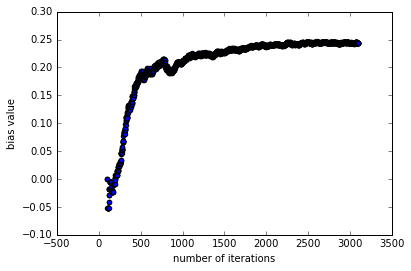

In [214]:
# bias_list
time_pts = range(t_o, t_o+train_steps+1)
# print(cos_sq_avg_distances(init_weights_, gt_dict))
loss_graph = np.mean(np.array(losses_list), axis=0)
sine_graph = np.mean(np.array(avg_scores_list), axis=0)
plt.scatter(time_pts, np.array(bias_list)[:,2])
plt.xlabel('number of iterations')
plt.ylabel('bias value')
plt.savefig('bias_plot_wc.eps')
#plt.savefig('dim8_datainit_bias_original_example.eps')
#len(loss_graph)
#plt.scatter(time_pts[1:], loss_graph[1:])
#plt.scatter(time_pts, sine_graph)
#plt.plot(time_pts, learn_rate_list)
#firing_list = np.array(firing_list)
# offset = -1
# plt.scatter(time_pts[:50], firing_list[offset-50:offset,0])

In [196]:
## cache loss here
avg_scores_list_nwc = avg_scores_list
#avg_scores_list_wc = avg_scores_list

## Modified SGD Training

In [33]:
## algorithmic params
mini_batch_size = 1
b_appx_batch_size = 100
weights_all = list()
tf.reset_default_graph()

In [34]:
# a = np.expand_dims(np.array([1., 1., 1.]), axis=0)
# b = 1.0*np.array(range(6)).reshape([3,2])
# prod = tf.matmul(a, b)
# bias = np.array([1.,-10.])
# res1 = tf.nn.relu(tf.add(prod,bias))
# res2 = tf.matmul(res1, b.T)
# loss = tf.reduce_mean(tf.reduce_sum(tf.square(a-res2), axis=1))
# with tf.Session() as sess:
#     print(sess.run([prod, res1, res2, loss]))
# init_weights_ = weights_all
# init_bias = bias_init(init_weights_, 2, 200, batch_data_generator, 2*dim, noise_bound)
# with tf.Session() as sess:
#     init_bias_ = sess.run(init_bias)

In [35]:
## Relu - autoencoder model with tied weights

### parameters to learn
#init_weights = tf.random_normal([width, dim], dtype=tf.float64)
weights = tf.Variable(init_weights_, name='weights_mod', dtype=tf.float64)
bias = tf.Variable(init_bias_, trainable=False, dtype=tf.float64)
#bias = tf.Variable(np.zeros(width), name = 'bias_mod', trainable=True, dtype=tf.float64)

### define model and loss
def encoder(weights, bias, x):
    return tf.add(tf.matmul(x, tf.transpose(weights)), bias)
def decoder(weights, h, activation):
    if activation == 'relu':
        return tf.matmul(tf.nn.relu(h), weights)
    else:
        print('activation function not implemented')
        exit(0)

def data_wise_mean_sq_loss(x, weights, bias):
    x_hat = decoder(weights, encoder(weights, bias, x), 'relu')
    return tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=1))

# def batch_wise_mean_sq_loss(batch_x, weights, bias):
#     batch_x_hat = decoder(weights, encoder(weights, bias, batch_x), 'relu')
#     print(batch_x_hat.get_shape())
#     return tf.reduce_mean(tf.square(batch_x - batch_x_hat), axis=1)

#x_gt = tf.placeholder(tf.float64, [dim,])
batch_x_gt = tf.placeholder(tf.float64, [mini_batch_size, dim])
batch_x_update_b = tf.placeholder(tf.float64, [b_appx_batch_size, dim])
### define optimizer  
global_step = tf.Variable(t_o, trainable=False)
rescale_param = tf.Variable(1/float(2**2) - 1, trainable=False, dtype=tf.float64)
####
learning_rate = c_prime
decay_steps = 1
decay_rate = 1.0
increment_global_step_op = tf.assign(global_step, global_step+1)
##
learn_rate = tf.train.inverse_time_decay(tf.cast(learning_rate, tf.float64), global_step, decay_steps, decay_rate)
#learn_rate = 0.1
init_eval_batch = batch_data_generator(dim, noise_bound, 100, dict_type, dict_size, gt_dict)
init_eval_batch = np.array(init_eval_batch, dtype='float64')
init_loss = data_wise_mean_sq_loss(init_eval_batch, init_weights_, 0)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init_loss_ = init_loss.eval()
    
loss = tf.Variable(init_loss_, trainable=False)
update_loss_op = tf.assign(loss, data_wise_mean_sq_loss(batch_x_gt, weights, bias))
train_op = tf.train.GradientDescentOptimizer(learn_rate).minimize(data_wise_mean_sq_loss(batch_x_gt, weights, bias))

In [36]:
## Norm-controlled SGD training
norm_decay_rate = tf.train.inverse_time_decay(tf.cast(1, tf.float64), 
                                              tf.subtract(global_step, t_o), decay_steps, decay_rate)

create_row_normalize_op = tf.assign(weights, (1+norm_decay_rate) * tf.nn.l2_normalize(weights, dim=1))
#update_rescale_param_op = tf.assign(rescale_param, 1/(1+norm_decay_rate)**2 - 1)
# create_row_normalize_op = tf.assign(weights, (1+1) * tf.nn.l2_normalize(weights, dim=1))
update_rescale_param_op = tf.assign(rescale_param, 1/(1+1)**2 - 1)
#batch_x = batch_data_generator(dim, noise_bound, b_appx_batch_size)
# update_bias_op = tf.assign(bias, 
#                     tf.squeeze(tf.matmul(weights, tf.expand_dims(x_gt, axis=1)))*rescale_param)

# def get_bias_update(batch_x, weights, bias, width, batch_size, rescale_param):
#     if tf.shape(batch_x)==1:
#         print('wrong')
#     else:
# #         relu_activation = tf.nn.relu(tf.transpose(
# #             tf.add(tf.transpose(tf.matmul(weights, batch_x)),bias)))
#         #avg_activation = tf.reduce_mean(relu_activation, axis=1)
#         projection = tf.transpose(tf.matmul(batch_x, tf.transpose(weights)))    # width by batch_size
#         #print(projection.get_shape())
#         relu_activation = tf.nn.relu(tf.transpose(tf.add(tf.transpose(projection), bias)))
#         #print(relu_activation.get_shape())
#         zero = tf.constant(0, dtype=tf.float64)
#         where = tf.not_equal(relu_activation, zero) ## logical indexing of relu_activation
#         indices = tf.where(where) ## indices of nonzero entries in relu_activation
#         #print('where shape', where.get_shape())
#         #temp = tf.count_nonzero(where,axis=1)
#         #print('nonzero', temp.get_shape())
#         ## calculate empirical prob of firing
#         nnz = tf.cast(tf.count_nonzero(where, axis=1), tf.float64)
#         zero_of_nnz = tf.equal(nnz, zero)
#         offsetted_nnz = tf.where(zero_of_nnz, tf.ones([width], dtype=tf.float64), nnz)
#         prob_firing = tf.divide(nnz, tf.cast(batch_size,tf.float64))
        
#         ## calculate empirical mean of projected value
#         shape = tf.constant([width, batch_size], dtype=tf.int64)
#         #print(indices.get_shape())
#         updated = tf.scatter_nd(indices, tf.gather_nd(projection, indices), shape)
#         updated = tf.reduce_sum(updated, axis=1)#
#         #offsetted_nnz = tf.scatter_add(nnz, indices_of_zero_in_nnz, tf.ones_like(indices_of_zero_in_nnz))
#         updated = tf.divide(updated, offsetted_nnz) * rescale_param ## shape = (width,)
#         #print('updated shape', updated.get_shape())
#         #print(relu_activation.get_shape())
#         new_bias = tf.add(tf.multiply(prob_firing,updated), tf.multiply(tf.subtract(tf.cast(1,tf.float64),prob_firing),bias))
#         return new_bias

# def get_bias_update(weights_new, weights, bias, rescale_param, batch_x):
#     batch_x = np.array(batch_x)
#     hidden = np.transpose(np.add(np.transpose(np.matmul(weights, batch_x.T)), bias))
#     hidden[hidden>0] = 1
#     hidden[hidden<=0] = 0
#     projection = np.matmul(weights_new, batch_x.T)
#     bias_new = np.mean(np.multiply(projection, hidden), axis=1)
#     return bias_new*rescale_param

def get_bias_update(weights_new, bias, rescale_param, batch_x):
    batch_x = np.array(batch_x)
    hidden = np.transpose(np.add(np.transpose(np.matmul(weights_new, batch_x.T)), bias))
    hidden[hidden>0] = 1
    hidden[hidden<=0] = 0
    projection = np.matmul(weights_new, batch_x.T)
    bias_new = np.mean(np.multiply(projection, hidden), axis=1)
    return bias_new*rescale_param

def reinitialize_weights(weights, bias, batch_x, gt_dict, dim, noise_bound, dict_type, dict_size):
    batch_x = np.array(batch_x)
    hidden = np.transpose(np.add(np.transpose(np.matmul(weights, batch_x.T)), bias))
    hidden[hidden>0] = 1
    hidden[hidden<=0] = 0
    ####
    firing_prob = np.mean(hidden, axis=1)
    ind = firing_prob <= 0.8
    data_raw = batch_data_generator(dim, noise_bound, np.sum(ind), dict_type, dict_size, gt_dict)
    data_norms = np.linalg.norm(data_raw, axis=1)
    ## normalize data
    weights[ind] = np.transpose(np.multiply(np.transpose(data_raw), data_norms))
    return weights
    

#new_bias = get_bias_update(batch_x_update_b, weights, bias, width, b_appx_batch_size, rescale_param)
#update_bias_op = tf.assign(bias, new_bias)
### Define some handy operations to update network variables
bias_new = tf.placeholder(tf.float64, [width])
update_bias_op = tf.assign(bias, bias_new)
###
weights_new = tf.placeholder(tf.float64, [width, dim])
update_weights_op = tf.assign(weights, weights_new)



#test_sample = batch_data_generator(dim, noise_bound, 100)

#min_scores_mod = list()
#weights_cache = init_weights_
#bias_cache = init_bias_
avg_scores_mod_list = list()
losses_mod_list = list()
control_norm = True
control_bias = True
reassign_weights = False
##### Training
for n_runs in range(10):
    avg_scores_mod = list()
    losses_mod = [init_loss_]
    #firing_list_mod = list()
    bias_list_mod = [init_bias_]
    weights_cached = init_weights_
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(train_steps):
            if i == 0:
                avg_scores_mod.append(cos_sq_avg_distances(init_weights_, gt_dict))
            #x = data_generator(dim, noise_bound, gt_dict)[0]
            batch_x = batch_data_generator(dim, noise_bound, mini_batch_size, dict_type, dict_size, gt_dict)
            #init_weights_ = sess.run(init_weights)
            #sess.run([train_op] , feed_dict={x_gt: x})
            _, weights_, bias_ = sess.run([train_op, weights, bias] , feed_dict={batch_x_gt: batch_x})
            
            if reassign_weights:
                weights_ = reinitialize_weights(weights_, bias_, batch_x, gt_dict, dim, 
                                                     noise_bound, dict_type, dict_size)
                _, weights_ = sess.run([update_weights_op, weights], feed_dict={weights_new: weights_})
            
            if control_norm:
                _,weights_ = sess.run([create_row_normalize_op, weights])  ## row-normalization of updated weights
            
            if control_bias:
                batch_x_new = batch_data_generator(dim, noise_bound, b_appx_batch_size, dict_type, dict_size, gt_dict)
                _, rescale_param_ = sess.run([update_rescale_param_op, rescale_param])
                #bias_ = get_bias_update(weights_, weights_cached, bias_, rescale_param_, batch_x_new)
                bias_ = get_bias_update(weights_, bias_, rescale_param_, batch_x_new)
                _,_ = sess.run([update_bias_op, bias], feed_dict={bias_new: bias_})
                weights_cached = weights_
            
            _, loss_ = sess.run([update_loss_op, loss], feed_dict={batch_x_gt: batch_x})
            ## get a fresh sample and update bias
            #x = data_generator(dim, noise_bound, gt_dict)[0]
            #bias_ = sess.run(update_bias_op, feed_dict={x_gt: x})  ## update bias using updated weights
            #batch_x_for_b = batch_data_generator(dim, noise_bound, b_appx_batch_size, gt_dict)
            #_, bias_ = sess.run([update_bias_op, bias],feed_dict={batch_x_update_b: np.array(batch_x_for_b)})
            #print('bias norm', np.sum(np.square(bias_))**0.5)

            n_steps, learn_rate_ = sess.run([increment_global_step_op, learn_rate])
            avg_scores_mod.append(cos_sq_avg_distances(weights_, gt_dict))
            losses_mod.append(loss_)
            #min_scores_mod.append(cos_sq_min_distances(weights_, gt_dict))
            get_bias_evolution_op(bias_list_mod, bias_)
            #get_firing_pattern_op(firing_list_mod, weights_, bias_, batch_x)
    avg_scores_mod_list.append(avg_scores_mod)
    losses_mod_list.append(losses_mod)
#         if (n_steps-t_o) % 100 == 0:
#             print('Training at %d-th iteration'% (n_steps-t_o))
#             print('cosine distances',)
#             print(cosine_squared_distances(weights_, gt_dict)[0])
#             #print('number of bias entries not updated is %d'%len(ind_))
#             print('change of weights', sess.run(tf.norm(weights_ - weights_cache)))
#             #print('change of bias', tf.norm(bias_ - bias_cache))
#             weights_cache = weights_
            #bias_cache = bias_
    #weights_final = weights_.eval()
    #bias_final = bias_.eval()
        

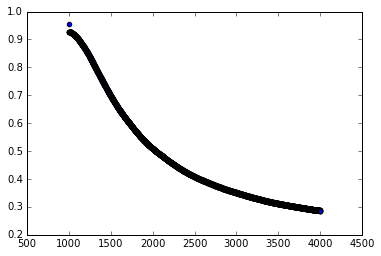

In [37]:
# def get_bias_update(weights_new, weights, bias, rescale_param, batch_x):
#     batch_x = np.array(batch_x)
#     hidden = np.transpose(np.add(np.transpose(np.matmul(weights, batch_x.T)), bias))
#     hidden[hidden>0] = 1
#     hidden[hidden<=0] = 0
#     projection = np.matmul(weights_new, batch_x.T)
#     res = np.multiply(projection, hidden)
#     return np.mean(res, axis=1)

# weights_new = np.array(range(6)).reshape([3,2])
# weights = np.array(range(1,7)).reshape([3,2])
# bias = np.array([range(3)])
# rescale_param = -0.5
# batch_x = np.array(range(20)).reshape([10,2])
# print(get_bias_update(weights_new, weights, bias, rescale_param, batch_x))
#tf.all_variables()
time_pts = range(t_o, t_o+train_steps+1)
loss_graph = np.mean(np.array(losses_mod_list), axis=0)
sine_graph = np.mean(np.array(avg_scores_mod_list), axis=0)
#plt.scatter(time_pts, loss_graph)
plt.scatter(time_pts, sine_graph)
#print(loss_graph[10])

In [38]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#best_appx, all_appx = cosine_distances(weights_, gt_dict)
#print(best_appx)
#print('best of init', cosine_distances(init_weights_, gt_dict)[-1])
print('at init', cosine_squared_distances(init_weights_, gt_dict))
print('after updates', cosine_squared_distances(weights_, gt_dict))
print('final loss', cos_sq_avg_distances(weights_, gt_dict))

('at init', array([ 0.04862386,  0.05349984,  0.02959986,  0.05008432,  0.06677185,
        0.02313751,  0.02916374,  0.05579509,  0.05323849,  0.03993386]))
('after updates', array([ 0.52279908,  0.89986445,  0.93055161,  0.59768246,  0.54911088,
        0.43816488,  0.63893909,  0.64475812,  0.76243575,  0.76963417]))
('final loss', 0.32460595082793064)


In [39]:
#np.mean(firing_list_mod, axis=0)

In [197]:
avg0 = np.mean(np.array(avg_scores_list_nwc), axis=0)
std0 = np.std(np.array(avg_scores_list_nwc), axis=0)
avg1 = np.mean(np.array(avg_scores_list_wc), axis=0)
std1 = np.std(np.array(avg_scores_list_wc), axis=0)
avg2 = np.mean(np.array(avg_scores_mod_list), axis=0)
std2 = np.std(np.array(avg_scores_mod_list), axis=0)
#len(std2)

In [131]:
print(avg_loss_ODL, avg1[-1], avg2[-1])
print(avg2[0])

(0.8707691813610946, 0.5394942895990591, 0.28695090408698476)
0.955015155644


## Plotting


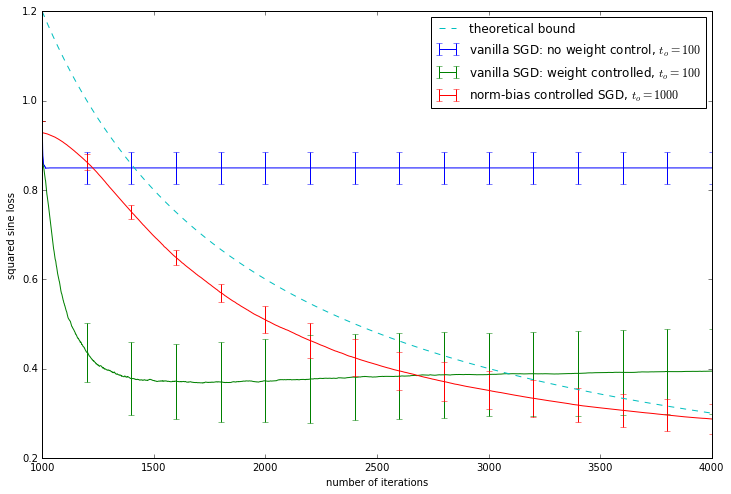

In [198]:
time_pts_o = range(t_o, t_o+train_steps+1)
time_pts_theo = range(t_o+900, 900+t_o+train_steps+1)
appx_func = [1200/float(t) for t in time_pts]
fig, ax = plt.subplots(figsize=[12,8])
# ax.plot(time_pts, avg1[:101])
# ax.plot(time_pts, avg2[:101])
ax.errorbar(time_pts_o, avg0, yerr=std0, errorevery=200, label='vanilla SGD: no weight control, $t_o=100$')
ax.errorbar(time_pts_o, avg1, yerr=std1, errorevery=200, label='vanilla SGD: weight controlled, $t_o=100$')
ax.errorbar(np.array(time_pts_o), avg2, yerr=std2, errorevery=200, label='norm-bias controlled SGD, $t_o=1000$')
# ax.scatter(time_pts, avg1, label='original')
# ax.scatter(time_pts, avg2, label='modified')
#ax.plot(time_pts_o, appx_func, '--',label='theoretical bound for $t_o=100$')
ax.plot(time_pts_o, appx_func, '--',label='theoretical bound')
# ax.plot(time_pts, [cos_sq_avg_distances(init_weights_, gt_dict)]*train_steps, label='initial loss')
# fig.savefig('original.eps')
ax.set_xlabel('number of iterations')
ax.set_ylabel('squared sine loss')
ax.legend(loc=1)
#ax.loglog()
#fig.savefig('loglog_dim100_k10' + '.eps')
#fig.savefig('dim8_datainit' + 'to_' + str(t_o) + '_cprme_' + str(c_prime) + '.eps')

In [62]:
# print(cosine_squared_distances(weights_, gt_dict))
#weights_all.append(weights_)
#weights_all = np.append(weights_all[0], weights_all[1], axis=0)
#print(cos_sq_avg_distances(weights_all, gt_dict))
#len(weights_all)

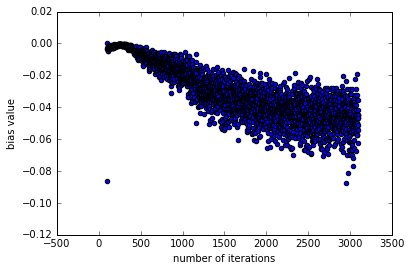

In [222]:
plt.scatter(time_pts, np.array(bias_list_mod)[:,5])
plt.xlabel('number of iterations')
plt.ylabel('bias value')
plt.savefig('bias_mod_example2.eps')
#bias_list_mod
#np.histogram(bias_list_mod[:,0])
#len(time_pts)

In [25]:
# from exp import maybe_pickle
# import math

# def get_data_and_plot(fnames, pname, pvalues, varname, value_list, algo):
#     fig, ax = plt.subplots()
#     for fname in fnames:
#         #print(fname)
#         evaluations_over_var = maybe_pickle(fname)
#         #fname = 'norm_controlled_data_dim_32_data_dim_2_4_8_16_32width4'
#         #evaluations_over_var = maybe_pickle(fname)
#         #print(evaluations_over_var)
#         #y_array2, y_err_array2 = maybe_pickle(fname2)
#     #     cprime, t_o = algo.eta_params
#     #     x = range(t_o, t_o+train_steps+1)
#     #     appx_func = [40/float(t) for t in x]
#         y_array, y_array_err = zip(*evaluations_over_var)
#         #print(np.array(y_array))
#         #fig, ax = plt.subplots()
#         y = np.array(y_array)[:,-1]
#         y_err = np.array(y_array_err)[:,-1]
#         if varname == 'learn_rate':
#             myxticks = value_list
#             print(myxticks)
#             x = range(len(myxticks))
#             ax.set_xticks(x)
#             ax.set_xticklabels(myxticks)
#             ax.scatter(x, y)
#         else:
#     #         myxticks = value_list
#     #         print(myxticks)
#     #         #x = range(len(myxticks))
#     #         xlist = map(float,value_list)
#     #         ax.set_xticks(xlist)
#     #         ax.set_xticklabels(myxticks)
#             #ax.scatter(value_list, y)
#             #ax.plot([0],y[0],'r*')
#             start_idx = fname.index('w')
#             ax.plot(value_list, y, '--o', label=fname[start_idx:])
#             #ax.plot(value_list,y2, '--ro', label = 'original')
#             ax.legend(loc=4)
#         #ax.set_xlim(xmin=-2)
#     # for idx, y in enumerate(y_array.tolist()):
#     #     string = ('%s = %s' %(varname, str(value_list[idx])))
#     #     y_err = y_err_array[idx]
#     #     ax.errorbar(x, y, yerr=y_err, errorevery=200, label=string)
#     # ax.plot(time_pts, avg1[:101])
#     # ax.plot(time_pts, avg2[:101])
#     #ax.errorbar(x, y, yerr=yerr, errorevery=200, label=arguments['<algo>'])
#     #ax.plot(x, appx_func, label='theoretical bound')
#     #ax.set_title('squared sin loss vs %s' %varname)
#     ax.set_title('loss versus dimension with different network widths')
#     ax.set_xlabel('data dimension')
#     ax.set_ylabel('squared sine error')
# #     pvalues_list = pvalues.split(',')
# #     pvalues = '_'.join(pvalues_list)
#     if varname == 'learn_rate':
#         value_list = ['-'.join(v.split(',')) for v in value_list]
#     vvalues = '_'.join(value_list)
#     #plt.show()
#     #fname = algo +'_'+ pname +'_'+pvalues+'_'+ varname +'_' + vvalues
#     fname = algo +'_'+ varname +'_' + vvalues
#     fig.savefig(fname+'.eps')
#     #_ = maybe_pickle(fname, data=[y_array, y_err_array])

In [26]:
# fnames = list()
# fname = 'norm_controlled_data_dim_32_data_dim_2_4_8_16_32width'
# for i in range(4):
#     fnames.append(fname + str(2**(i+2)))
# #fname2 = 'norm_controlled_data_dim_32_data_dim_2_4_8_16_32width8'
# #pname = 'batch_size'
# #pvalues = '1,200-0-100'
# varname = 'data_dim'
# value_list = map(str, [4,8,16,32,64])
# algo = 'norm_controlled'
# get_data_and_plot(fnames, 0, 0, varname, value_list, algo)